
<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSC_Mm1-IrFG4mSteKHw4W8ekcWybVi7Lj2_Q&usqp=CAU"></center>


 <center><h1 style="font-weight: bold;">Covid-19 Behavior Analysis</h1></center>




>For almost a year the world has been struggling with the coronavirus, we can observe the effects of pandemic in every aspect of life. Governments are introducing prohibitions in order to reduce the number of infections so that the health services can cope with it. however, such numerous prohibitions significantly affect the economy and the mental state of people. 

>In our project we are going to **analyse available covid-19 global data**, which describe among others the total numbers of infected cases, hospitalization, deaths, mobility, government restricyions and try to find which restrictions have the best effect in reducing the number of infections. 
>In addition we are going to find the age range of people who are most likely to be affected by covid to know who should be isolated and who can normally participate in social life and work. 

>The main goal of this Pipline Aplication is to help **find a balanced plan** to deal with the coronavirus so that the global economy suffers less from the pandemic.





## **Objectives**
- **Classify data** in different groups using clustring algorithms. 
- Find which **restrictions have the best effect in reducing** the number of infections
- Find the **age range** of people who are most likely to be affected by covid
- Find **corellation between the restrictions and number of cases** in order to find which features is the most importartant in case of reducing morbidity.
- **Predict the development of the covid situation** with introduction of different sets of restrictions that proved to be the best in the previous analysis

<center><img src="http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png"><img src="http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png"></center>

<center><img src="https://upload.wikimedia.org/wikipedia/commons/0/05/Scikit_learn_logo_small.svg"></center>





## **Technical Requirements**

#### **Technology**:
- **Google Colab**
- **Python**: 
    - Scikit-learn
    - PySpark
    - Matplotlib
    - Plotly



#### **Data sources** :
- [www.europeandataportal.eu](https://www.europeandataportal.eu/data/datasets?locale=en&query=covid%20&page=1&catalog=datos-gob-es&minScoring=0)
- [datos.gob.es](https://datos.gob.es/en/catalogo?q=coronavirus&g-recaptcha-response=&sort=metadata_created+desc)
- [www.kaggle.com](https://www.kaggle.com/danigarci1/covid19-spain/data) 
- [github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)
- [github.com/owid/covid-19-data](https://github.com/owid/covid-19-data/tree/master/public/data)
- [github.com/timriffe/covid_age](https://github.com/timriffe/covid_age)

## **Possible Difficulties**
- Some of the taget data are not up to date
- Big amount of missing values, because often there is no uniform data
- Informations are divided into various files in different format (like one for genomic sequencing, other for cases, for previous diseases, addictions and so on)

## **Stakeholders**
- Ministry of Health
- Biological ressearchers
- Medicine industries

## **Project Team:** 
- Diaa Abou Raied 
- Aleksandra Samol 
- Rafael Câmara Pereira 

## **Workflow**

The next steps of data processing and modeling are presented below.

*   **Data exploration** - review of dataframes and columns, analysis of what should be changed in the data format and how to clean them to make them suitable for the next steps.
*   **Data Pre-Processing** - Cleaning data from unnecessary information, missing values, changing the format of some data.
*   **Clustering** - based on the number of tests performed and the number of new cases
*    **Selection** of the most important restrictions based on correlation matrix
*    **Model** number of new cases in future based on the most important restrictions
*     **Decesion tree** to predict the number of the total_deaths




# **Application** 

### **1.Loading required libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import io 
import glob 
import numpy as np
import datetime

In [ ]:
import plotly.graph_objects as go

In [ ]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark


In [ ]:

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('covid19_kmeans')
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeans, KMeansModel

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [ ]:
from pyspark.ml.clustering import KMeans

### **2.Data Exploration**

As a main data source we were using [github.com/owid/covid-19-data](https://github.com/owid/covid-19-data/tree/master/public/data) because it combines all the databases listed at the introduction, except all information on the restrictions introduced by the authorities of the countries.

**The main table contains 50 columns and provides data for 192 countries. 
  The most important of them contain information such as:** 

*   Date
*   Country
*   Total number of cases
*   New cases
*   Deaths
*   Cases per million / thousand
*   Tests number
*   Informations about age distribution

In [ ]:
len(data1['location'].unique())

192

In [ ]:
data1=pd.read_csv('/content/drive/MyDrive/datasets /owid-covid-data.csv')
data1.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-01-23,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-24,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-25,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-26,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-27,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [ ]:
data1.info()

**The next dataset is a table containing information about restrictions introduced by the authorities in a given period.**

> 



This table contains 23 columns with type of restriction.

In [ ]:
data2=pd.read_csv('/content/drive/MyDrive/datasets /restrictions.csv')
data2 = data2.rename(columns={"Year": "date"})
data2.head()


,Country,date,school_closures,workplace_closures,cancel_public_events,restriction_gatherings,close_public_transport,stay_home_requirements,restrictions_internal_movements,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_healthcare,investment_vaccines,facial_coverings,vaccination_policy,stringency_index,containment_index
0,Afghanistan,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **3.Data Pre-Processing**
Before analyzing the data, we need to clear them as they have a lot of missing data and different dates format.

In order to investigate **how the introduced restrictions affect** the number of new cases, we **"shifted"** data about new cases (all table owid-covid) by **10 days** in relation to the date of the introduced restrictions.

In [ ]:
# Change format of date from %Y-%m-%d to number of day in year adding 10 days shift
for i in range (0,len(data1["date"])):
    day= data1['date'][i]
    day = datetime.datetime.strptime(day, '%Y-%m-%d')
    day_of_year = (day - datetime.datetime(day.year, 1, 1)).days + 11
    data1.iloc[i, data1.columns.get_loc('date')] = day_of_year

In [ ]:
data1=pd.read_csv('/content/drive/MyDrive/datasets /owid_shift_10.csv')

In [ ]:
# Change format of date in both datasets
data1['date'] = pd.to_datetime(data1['date'])
data1['date'] = data1['date'].dt.strftime('%d/%m/%Y')

In [ ]:
data2['date'] = pd.to_datetime(data2['date'])
data2['date'] = data2['date'].dt.strftime('%d/%m/%Y')

In [ ]:
# Change column name Country to location to anable merging dataframes
data2=data2.rename(columns={'Country': 'location'})


In [ ]:
# Merge dataframes
new_df = pd.merge(data1, data2,  how='left', left_on=['date','location'], right_on = ['date','location'])

In [ ]:
new_df.to_csv('/content/drive/MyDrive/datasets /data_merged.csv')


In [ ]:
new_df = pd.read_csv('/content/drive/MyDrive/datasets /data_merged.csv')

In [ ]:
new_df.index.name = "ID"
new_df['ID'] = new_df.index

In [ ]:
# deleting unuseles columns
new_df = new_df.replace(np.nan, 0)
new_df = new_df.drop(['tests_units', 'iso_code', 'continent'], axis=1)

After merge operation we have dataframe with 71 columns

In [ ]:
new_df.info()

In [ ]:
# List of all features names:
features_names = list(new_df.columns[:-1])


In [ ]:
## convert Pandas dataFrame to spark dataFrame
allData = sc.createDataFrame(new_df)


We are going to analyse data since 1 case occured in a given country, therefore we remove from the table rows where the total number of cases is smaller than 1.

We also delete data with no tests performed.

In [ ]:
allData = allData[(allData['total_cases'] > 0) ]
allData = allData[(allData['total_tests_per_thousand'] > 0) ]

In [ ]:
allData.show()

In [ ]:
## change all values to float
for col in ["new_tests_per_thousand", "new_cases"]:
    if col in features_names:
        allData = allData.withColumn(col,allData[col].cast('float'))

### **4.Clustering based on the number of tests performed and the number of new cases**


In [ ]:

new_df= new_df[(new_df['new_tests'] > 0) ]

In [ ]:
new_df

#### Correlation new_cases - new_tests

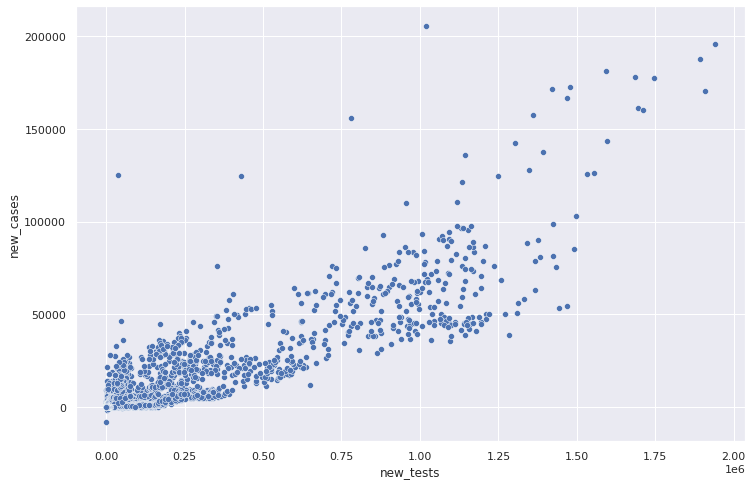

In [ ]:
sns.diverging_palette(250, 30, l=65, as_cmap=True)
sns.set(rc={'figure.figsize':(12, 8)})
sns.scatterplot(data=new_df, x="new_tests", y="new_cases")

As can be seen in the chart above, there is quite a clear positive correlation between the number of new cases and the number of tests performed.

We decided to group all results based on the number of tests per thousand and the number of new cases, and only take for further analysis the groups where the average number of tests was the highest.

As we did not know the number of clusters into which data should be divided for clustering, we used K-means clustering algorithm.

In [ ]:
# CHose features to classification 
features_new = ["new_tests_per_thousand", "new_cases"]
vecAssembler = VectorAssembler(inputCols=features_new, outputCol="features")

In [ ]:
df_kmeans = vecAssembler.transform(allData).select("ID","features")
df_kmeans.show()

+----+--------------------+
|  ID|            features|
+----+--------------------+
|2579|         [0.0,478.0]|
|2586|         [0.0,344.0]|
|2593|         [0.0,137.0]|
|2594|[0.21600000560283...|
|2595|[0.31499999761581...|
|2596|[0.34000000357627...|
|2597|[0.42199999094009...|
|2598|[0.32199999690055...|
|2599|[0.37299999594688...|
|2600|[0.23899999260902...|
|2601|[0.32100000977516...|
|2602|[0.17100000381469...|
|2603|[0.19200000166893...|
|2604|[0.33799999952316...|
|2605|[0.45199999213218...|
|2606|[0.58700001239776...|
|2607|[0.56800001859664...|
|2608|[0.42100000381469...|
|2609|[0.31799998879432...|
|2610|[0.49399998784065...|
+----+--------------------+
only showing top 20 rows



In [ ]:
# Find best number of k (clusters)
cost = np.zeros(30)
for k in range(2,30):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df_kmeans.select('features'))
    cost[k] = model.summary.trainingCost

Text(0, 0.5, 'cost')

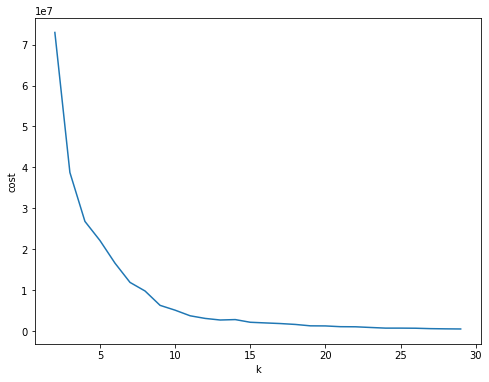

In [ ]:
# Plot Cost for calculated k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,30),cost[2:30])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Based on above plot we have choosen k = 15

In [ ]:
# make k-means clustering model with k based on previous calculations
k = 15
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[8.35398781e-01 2.85358226e+03]
[1.96738889e+00 6.10007361e+04]
[4.87810004e+00 1.80816800e+05]
[1.72029032e+00 3.46637742e+04]
[3.78937501e+00 1.22773000e+05]
[1.336000e+00 9.162756e+04]
[2.16062286e+00 1.57574971e+04]
[1.14201760e+00 5.29830253e+03]
[1.65666337e+00 4.65492079e+04]
[   1.32853973 1126.78383562]
[2.26648235e+00 2.40204882e+04]
[1.3461641e+00 9.2267000e+03]
[1.53735002e+00 7.63501500e+04]
[  0.80435979 119.10931495]
[4.24671422e+00 1.51338714e+05]


In [ ]:
transformed = model.transform(df_kmeans).select('ID','prediction')
rows = transformed.collect()


In [ ]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+----+----------+
|  ID|prediction|
+----+----------+
|2579|        13|
|2586|        13|
|2593|        13|
|2594|        13|
|2595|        13|
|2596|        13|
|2597|        13|
|2598|        13|
|2599|        13|
|2600|        13|
|2601|        13|
|2602|        13|
|2603|        13|
|2604|        13|
|2605|        13|
|2606|        13|
|2607|        13|
|2608|        13|
|2609|        13|
|2610|        13|
+----+----------+
only showing top 20 rows



In [ ]:
## join predictions with all data frame
df_pred = df_pred.join(allData, 'ID')
df_pred.show()
pddf_pred = df_pred.toPandas().set_index('ID')

+-----+----------+----------+--------------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+--------------------+--------------+------------------+-----------+------------------+----------+-------------+-----------------+------------------+---------------+---------------------+-------------------+--------------+------------+----------------------+--------------------------+---------------+-----------------------+------------+---------------+------------------+

#### Display clustered data

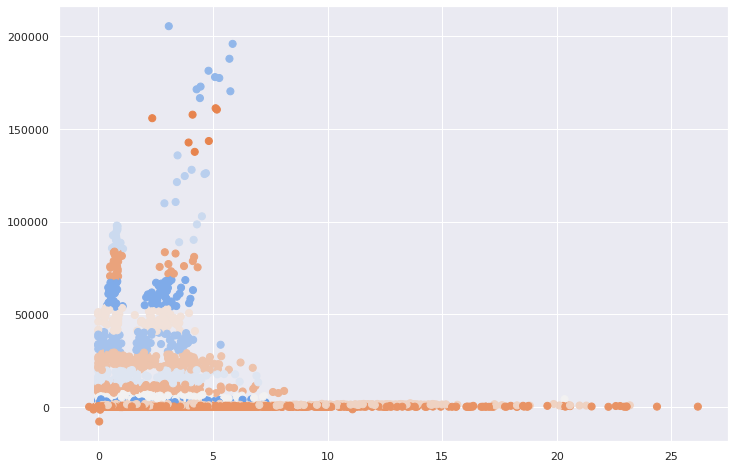

In [ ]:
my_cmap = sns.diverging_palette(250, 30, l=65, as_cmap=True)
plt.scatter(pddf_pred.new_tests_per_thousand, pddf_pred.new_cases, c=pddf_pred.prediction, s=50, cmap=my_cmap)

In [ ]:
pddf_pred.index.name = "ID"
pddf_pred['ID'] = pddf_pred.index


Based on calculated clusters we calculated mean number of new tests per thousand for each cluster and then we select 10 clusters with the highest mean value.

In [ ]:
df_pred_test = pddf_pred[["ID", "prediction", "new_tests_per_thousand"]]
mean_test =pd.DataFrame({"mean"})
mean_test= df_pred_test.groupby('prediction')["new_tests_per_thousand"].mean()

In [ ]:
group_list = mean_test.index
mean_test = mean_test.to_frame()

In [ ]:
mean_test = mean_test.sort_values(by=['new_tests_per_thousand'])
group_list = list(mean_test.index[-10:])

In [ ]:
test_sele = pddf_pred[pddf_pred['prediction'].isin(group_list)]

In [ ]:
test_sele = test_sele[(test_sele['total_cases'] > 0) ]
test_sele = test_sele[(test_sele['total_tests_per_thousand'] > 0) ]

### **5.Selection of the most important restrictions**

At this stage, we will try to find which of the restrictions listed in the dataset have the greatest impact on reducing the number of new cases.

First of all, we remove the data from the main table, that are useless at that stage. 

In [ ]:
data = test_sele.drop(['life_expectancy',
 'human_development_index',
 'Unnamed: 0',
  'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'population',
 'population_density',
 'location',
 'date',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million',
 'total_tests',
 'new_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'positive_rate',
 'tests_per_case',
 'prediction'], axis=1)


In [ ]:
data

In [ ]:
## change all values to float
data = data.astype(float)

In order to find out which restrictions are most correlated with the number of new cases per million people, we made the correlation matrix

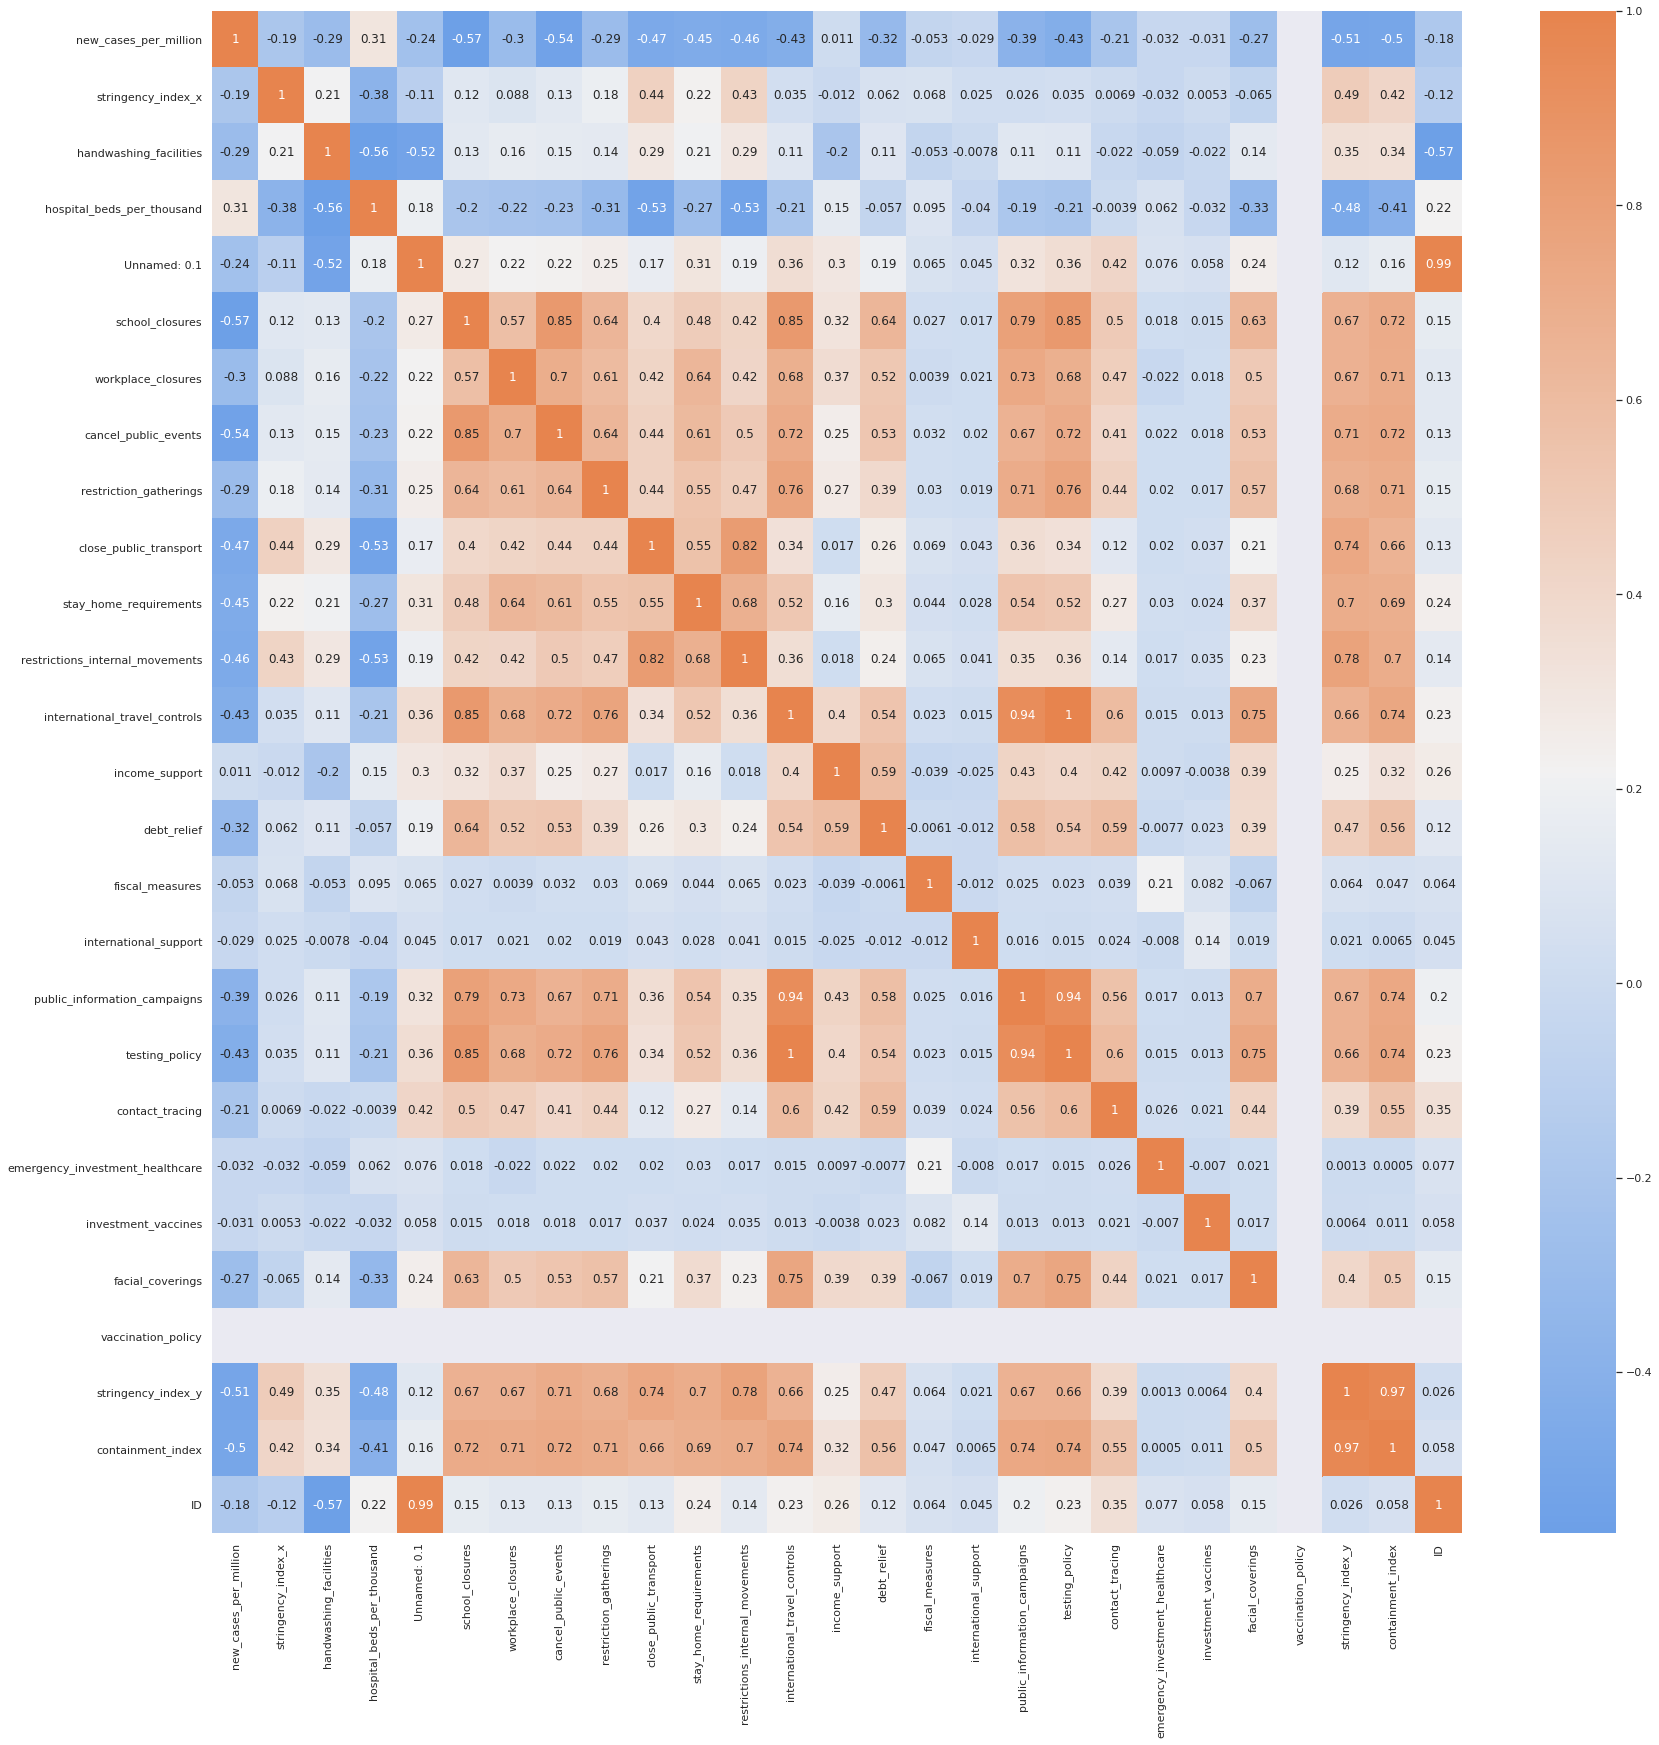

In [ ]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(28,28))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap=my_cmap)

Then we chose only **negative values**, because if we want to choose restrictions that reduce the number of cases, we have to take those that are **negatively correlated** with the number of new cases.



In [ ]:
corr_pairs = corrmat.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
negative_pairs = sorted_pairs[sorted_pairs < 0]
negative_pairs = negative_pairs.to_frame()
negative_pairs['pairs'] = negative_pairs.index

From all the pairs, we selected only those that contained **new_cases_per_milion**.

In [ ]:
negative_pairs['pairs'].str.contains('ID')
negative_pairs['pairs'] = negative_pairs['pairs'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
negative_pairs['if_cases'] = negative_pairs['pairs'].str.contains('new_cases_per_million')
pairs_cases = negative_pairs.loc[negative_pairs['if_cases'] == True]
pairs_cases = pairs_cases.drop_duplicates(subset = [0])
pairs_cases

0  ... if_cases
new_cases_per_million           school_closures        -0.565122  ...     True
                                cancel_public_events   -0.539995  ...     True
                                stringency_index_y     -0.506092  ...     True
containment_index               new_cases_per_million  -0.503656  ...     True
close_public_transport          new_cases_per_million  -0.472094  ...     True
restrictions_internal_movements new_cases_per_million  -0.462387  ...     True
stay_home_requirements          new_cases_per_million  -0.453627  ...     True
testing_policy                  new_cases_per_million  -0.429146  ...     True
public_information_campaigns    new_cases_per_million  -0.387045  ...     True
new_cases_per_million           debt_relief            -0.318403  ...     True
                                workplace_closures     -0.296007  ...     True
                                restriction_gatherings -0.288880  ...     True
                                handwashing_facilities -0.285540  ...     True
                                facial_coverings       -0.272407  ...     True
                                Unnamed: 0.1           -0.242064  ...     True
                                contact_tracing        -0.206602  ...     True
stringency_index_x              new_cases_per_million  -0.194380  ...     True
ID                              new_cases_per_million  -0.178605  ...     True
fiscal_measures                 new_cases_per_million  -0.052522  ...     True
emergency_investment_healthcare new_cases_per_million  -0.031727  ...     True
new_cases_per_million           investment_vaccines    -0.031307  ...     True
international_support           new_cases_per_million  -0.029369  ...     True

[22 rows x 3 columns]

#### **Based on correlation matrix the most important restrictions are:**

**Absolute correlation > 0.5**
*   school_closures
*   cancel_public_events

**Absolute correlation > 0.45**

*   close_public_transport
*   restrictions_internal_movements
*   stay_home_requirements

**Absolute correlation > 0.2**
*   public_information_campaigns
*   workplace_closures
*   handwashing_facilities
*   facial_coverings





### **6.Model number of new cases in future based on the most important restrictions**

After selecting the 5 most important restrictions, we decided to model the data and see how the graph of new cases will be shaped if these restrictions are applied.

In [ ]:
data_m = pd.read_csv('/content/drive/MyDrive/datasets /data_merged.csv')
data_m = data_m['date']
data_m = data_m.to_frame()
data_m['IDs'] = data_m.index
data =data.drop('ID', axis=1)
data['IDs'] = data.index
data_m = pd.merge(data_m, data, on='IDs')

In [ ]:
best_5_yes = data_m[((data_m['school_closures']>0) & (data_m['cancel_public_events']>0) & (data_m['stay_home_requirements']>0) & (data_m['restrictions_internal_movements']>0) & (data_m['close_public_transport']>0) )]
best_5_yes.to_csv('/content/drive/MyDrive/datasets /best_5_yes.csv')

In [ ]:
best_5_no = data_m[((data_m['school_closures']<1) & (data_m['cancel_public_events']<1) & (data_m['stay_home_requirements']<1) & (data_m['restrictions_internal_movements']<1) & (data_m['close_public_transport']<1) )]
best_5_no.to_csv('/content/drive/MyDrive/datasets /best_5_no.csv')

To keep the dates continuous, we calculated the median of new cases per million.

In [ ]:
best_5_yes_date = best_5_yes[['date', 'new_cases_per_million']].groupby(['date']).agg(['median'])
best_5_no_date = best_5_no[['date', 'new_cases_per_million']].groupby(['date']).agg(['median'])

In [ ]:
best_5_yes_date = best_5_yes_date.new_cases_per_million['median'].to_frame()
best_5_no_date = best_5_no_date.new_cases_per_million['median'].to_frame()

In [ ]:
best_5_yes_date['date'] = best_5_yes_date.index
best_5_no_date['date'] = best_5_no_date.index

Plot of new cases per million with the most important restrictions.

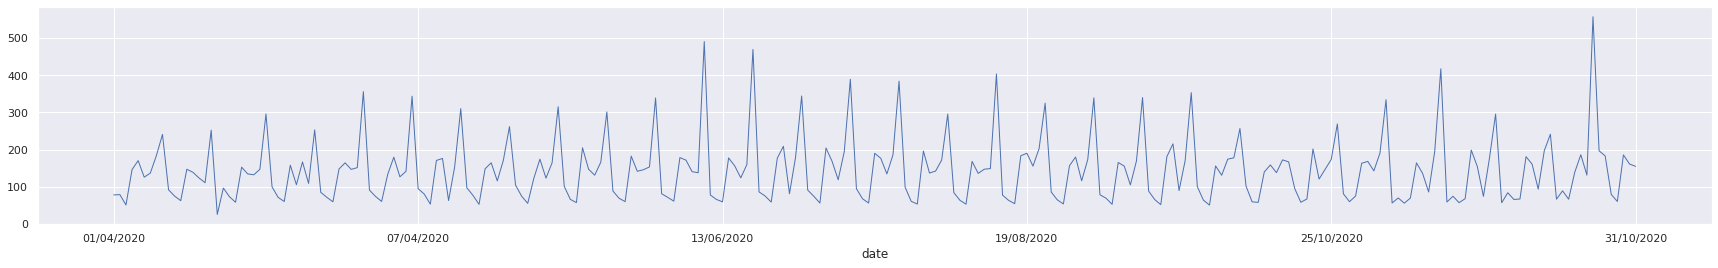

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(30, 4)})
best_5_yes_date['median'].plot(linewidth=1);


Plot of new cases per million without the most important restrictions.

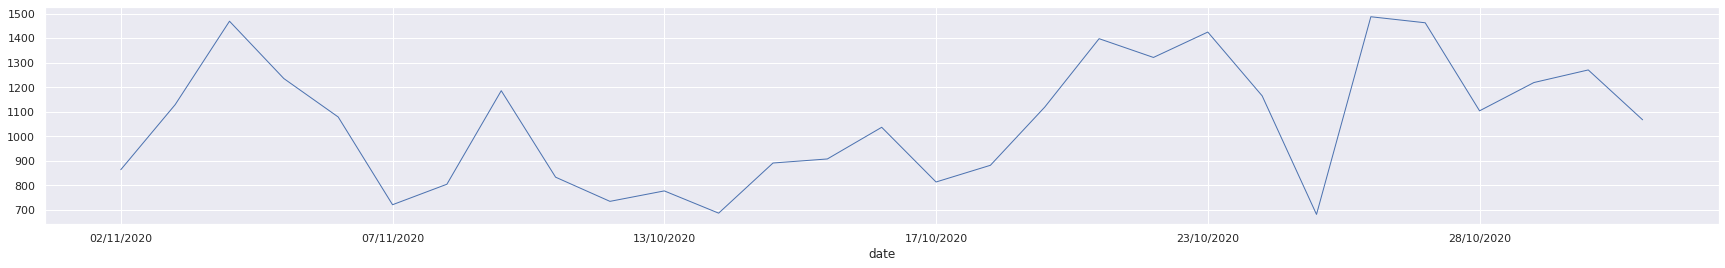

In [ ]:
sns.set(rc={'figure.figsize':(30, 4)})
best_5_no_date['median'].plot(linewidth=1);

Plot to compare new cases per million with and without introduced the most important restrictions 

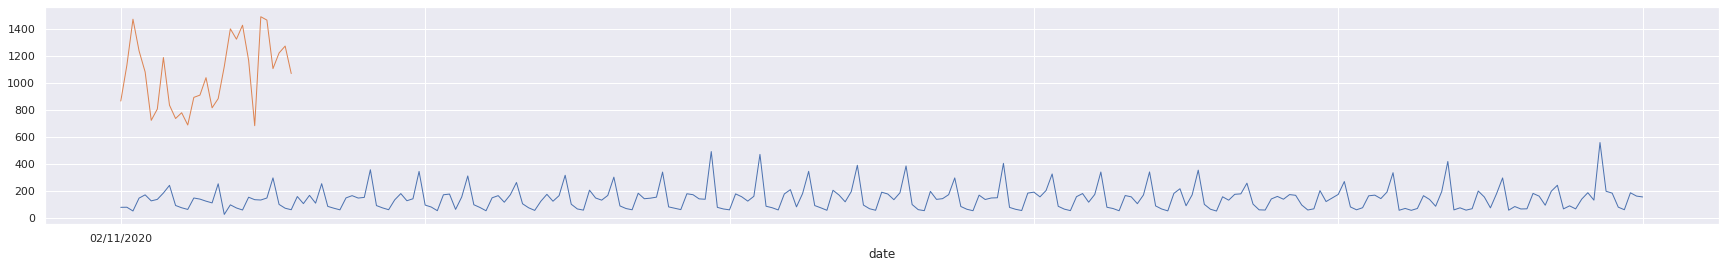

In [ ]:
sns.set(rc={'figure.figsize':(30, 4)})
best_5_yes_date['median'].plot(linewidth=1);
best_5_no_date['median'].plot(linewidth=1);

ARIMA Model

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
best_5_yes = pd.read_csv('/content/drive/MyDrive/datasets /best_5_yes_d.csv', 
                       index_col ='date', 
                       parse_dates = True) 

In [ ]:
best_5_yes = pd.read_csv('/content/drive/MyDrive/datasets /best_5_yes_d.csv') 

In [ ]:
best_5_yes = best_5_yes.drop('date.1', axis=1)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

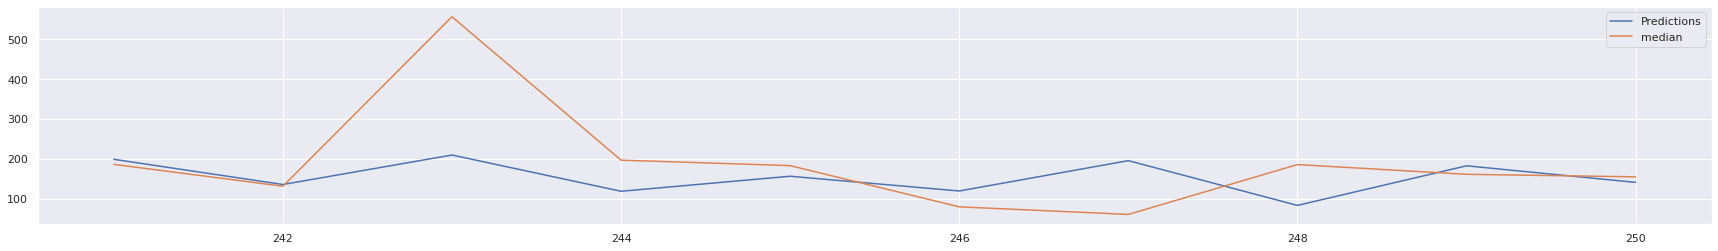

In [ ]:
train = best_5_yes.iloc[:len(best_5_yes)-10] 
test = best_5_yes.iloc[len(best_5_yes)-10:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['median'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 30)) 
  
result = model.fit() 
result.summary() 
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['median'].plot(legend = True) 

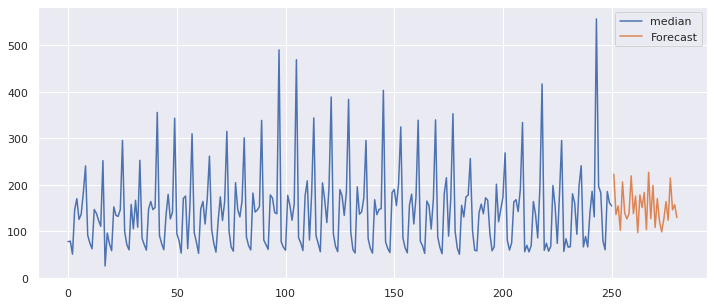

In [ ]:
# Train the model on the full dataset 
model = model = SARIMAX(best_5_yes['median'],  
                        order = (0, 1, 1),  
                        seasonal_order =(2, 1, 1, 30)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(best_5_yes),  
                          end = (len(best_5_yes)-1) + 30,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
best_5_yes['median'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True) 

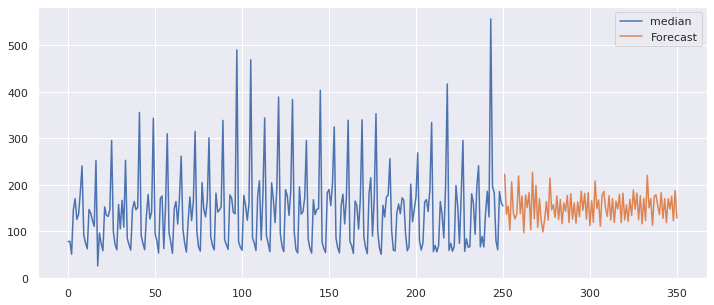

In [ ]:
# Train the model on the full dataset 
model = model = SARIMAX(best_5_yes['median'],  
                        order = (0, 1, 1),  
                        seasonal_order =(2, 1, 1, 30)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(best_5_yes),  
                          end = (len(best_5_yes)-1) + 100,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
best_5_yes['median'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True) 

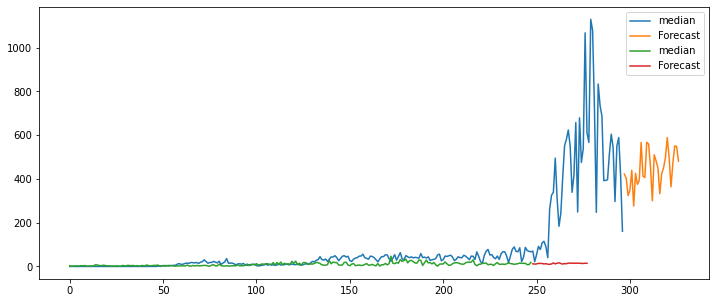

In [ ]:
# Plot the forecast values 
best_5_no['median'].plot(figsize = (12, 5), legend = True) 
forecast2.plot(legend = True) 
# Plot the forecast values 
best_5_yes['median'].plot(legend = True) 
forecast.plot(legend = True) 

### **7.Decesion tree to predict the number of the total_deaths** 

In [ ]:
#select the variables to use in the prediction 
decData1=data1[["total_cases","icu_patients","female_smokers","male_smokers","aged_65_older","aged_70_older","median_age","total_deaths"]]
decData1

,total_cases,icu_patients,female_smokers,male_smokers,aged_65_older,aged_70_older,median_age,total_deaths
0,NaN,NaN,NaN,NaN,2.581,1.337,18.6,NaN
1,NaN,NaN,NaN,NaN,2.581,1.337,18.6,NaN
2,NaN,NaN,NaN,NaN,2.581,1.337,18.6,NaN
3,NaN,NaN,NaN,NaN,2.581,1.337,18.6,NaN
4,NaN,NaN,NaN,NaN,2.581,1.337,18.6,NaN
...,...,...,...,...,...,...,...,...
60284,9822.0,NaN,1.6,30.7,2.822,1.882,19.6,275.0
60285,9822.0,NaN,1.6,30.7,2.822,1.882,19.6,275.0
60286,9950.0,NaN,1.6,30.7,2.822,1.882,19.6,276.0
60287,10129.0,NaN,1.6,30.7,2.822,1.882,19.6,277.0


In [ ]:
decData1=decData1[(decData1["total_cases"] >0)]
decData1 = decData1.replace(np.nan, 0)
decData1

,total_cases,icu_patients,female_smokers,male_smokers,aged_65_older,aged_70_older,median_age,total_deaths
32,1.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0
33,1.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0
34,1.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0
35,1.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0
36,1.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0
...,...,...,...,...,...,...,...,...
60284,9822.0,0.0,1.6,30.7,2.822,1.882,19.6,275.0
60285,9822.0,0.0,1.6,30.7,2.822,1.882,19.6,275.0
60286,9950.0,0.0,1.6,30.7,2.822,1.882,19.6,276.0
60287,10129.0,0.0,1.6,30.7,2.822,1.882,19.6,277.0


In [ ]:
inputs=decData1.drop(['total_deaths'],axis='columns')
target=decData1['total_deaths']

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier


In [ ]:
model=DecisionTreeClassifier()
#model = DecisionTreeClassifier(criterion="entropy", max_depth=3)

In [ ]:
#split the orginal data into two parts, 70% for training and 30% for testing 
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.3, random_state=1) # 70% training and 30% test


In [ ]:
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
X_test

,total_cases,icu_patients,female_smokers,male_smokers,aged_65_older,aged_70_older,median_age
3035,22106.0,24.0,28.4,30.9,19.202,13.748,44.4
153,29705.0,0.0,0.0,0.0,2.581,1.337,18.6
1560,13922.0,0.0,0.0,0.0,2.405,1.362,16.8
12477,18187.0,0.0,6.4,17.4,9.468,5.694,33.6
2081,196543.0,0.0,16.2,27.7,11.198,7.441,31.9
...,...,...,...,...,...,...,...
9910,781.0,0.0,2.1,16.5,4.460,3.437,25.7
2067,122524.0,0.0,16.2,27.7,11.198,7.441,31.9
56638,1811393.0,7591.0,19.1,24.6,15.413,9.732,38.3
38926,648.0,0.0,0.1,15.4,2.553,1.378,15.1


In [ ]:
pred = model.predict(X_test)

In [ ]:
# check the Accuracy sof the prediction model:
print("Accuracy:",metrics.accuracy_score(y_test, pred))


Accuracy: 0.5102489492402199


the accuracy that we got around 50% 

In [ ]:
X_test['death_prediction'] = pred.tolist()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_test

,total_cases,icu_patients,female_smokers,male_smokers,aged_65_older,aged_70_older,median_age,death_prediction
3035,22106.0,24.0,28.4,30.9,19.202,13.748,44.4,721.0
153,29705.0,0.0,0.0,0.0,2.581,1.337,18.6,617.0
1560,13922.0,0.0,0.0,0.0,2.405,1.362,16.8,382.0
12477,18187.0,0.0,6.4,17.4,9.468,5.694,33.6,150.0
2081,196543.0,0.0,16.2,27.7,11.198,7.441,31.9,3441.0
...,...,...,...,...,...,...,...,...
9910,781.0,0.0,2.1,16.5,4.460,3.437,25.7,7.0
2067,122524.0,0.0,16.2,27.7,11.198,7.441,31.9,2178.0
56638,1811393.0,7591.0,19.1,24.6,15.413,9.732,38.3,107674.0
38926,648.0,0.0,0.1,15.4,2.553,1.378,15.1,20.0


In [ ]:

totalDeath=decData1[["total_deaths"]]
X_test['total_deaths'] = totalDeath

#res=pd.merge(totalDeath,X_test, left_index=True, right_index=True)
X_test.head(30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,total_cases,icu_patients,female_smokers,male_smokers,aged_65_older,aged_70_older,median_age,death_prediction,total_deaths
3035,22106.0,24.0,28.4,30.9,19.202,13.748,44.4,721.0,723.0
153,29705.0,0.0,0.0,0.0,2.581,1.337,18.6,617.0,638.0
1560,13922.0,0.0,0.0,0.0,2.405,1.362,16.8,382.0,332.0
12477,18187.0,0.0,6.4,17.4,9.468,5.694,33.6,150.0,154.0
2081,196543.0,0.0,16.2,27.7,11.198,7.441,31.9,3441.0,3596.0
49943,153222.0,0.0,27.4,31.4,19.436,13.799,45.5,16606.0,15447.0
19863,14.0,0.0,28.2,33.1,21.453,15.957,46.6,0.0,0.0
26697,19848.0,0.0,11.2,33.7,27.049,18.493,48.2,977.0,978.0
40266,240848.0,0.0,2.8,36.7,4.495,2.780,23.5,5058.0,4983.0
12429,1715.0,0.0,6.4,17.4,9.468,5.694,33.6,12.0,12.0


In [ ]:
final=pd.merge(data1.location,X_test, left_index=True, right_index=True)
final1=pd.merge(data1.date,final, left_index=True, right_index=True)

In [ ]:
final1

,date,location,total_cases,icu_patients,female_smokers,male_smokers,aged_65_older,aged_70_older,median_age,death_prediction,total_deaths
34,2020-02-26,Afghanistan,1.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0,0.0
35,2020-02-27,Afghanistan,1.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0,0.0
40,2020-03-03,Afghanistan,2.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0,0.0
42,2020-03-05,Afghanistan,4.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0,0.0
43,2020-03-06,Afghanistan,4.0,0.0,0.0,0.0,2.581,1.337,18.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
60264,2020-11-08,Zimbabwe,8531.0,0.0,1.6,30.7,2.822,1.882,19.6,254.0,253.0
60269,2020-11-13,Zimbabwe,8765.0,0.0,1.6,30.7,2.822,1.882,19.6,257.0,257.0
60271,2020-11-15,Zimbabwe,8829.0,0.0,1.6,30.7,2.822,1.882,19.6,257.0,257.0
60274,2020-11-18,Zimbabwe,8981.0,0.0,1.6,30.7,2.822,1.882,19.6,260.0,261.0


In [ ]:
res=final1.groupby(['location','median_age'])[['death_prediction']].max()
res.head(30)

,,death_prediction
location,median_age,
Afghanistan,18.6,1795.0
Albania,38.0,810.0
Algeria,29.1,5158.0
Andorra,0.0,76.0
Angola,16.8,425.0
Antigua and Barbuda,32.1,4.0
Argentina,31.9,38928.0
Armenia,35.7,2987.0
Australia,37.9,908.0


In [ ]:
res=res[(res["death_prediction"] >0)]
res = res.replace(np.nan, 0)
res.head(30)

,,death_prediction
location,median_age,
Afghanistan,18.6,1795.0
Albania,38.0,810.0
Algeria,29.1,5158.0
Andorra,0.0,76.0
Angola,16.8,425.0
Antigua and Barbuda,32.1,4.0
Argentina,31.9,38928.0
Armenia,35.7,2987.0
Australia,37.9,908.0


##**Conclusion**

In our project, we have tried to analyse and understand the behaviour of the covid-19 virus, during the last year. We have used clustering techniques “K_means” in order to classify the data in different groups and predict the number of tests per thousand , number of cases per million. Based on the restriction data that we have got, we figured out the most effective restrictions that the governments can put in order to reduce the Spreading of the virus , and based on the best features hat we have got, we built an ARIMA model, in order to forecast the number of cases in the future. We wanted to figure out the relation between the age variables that we have in addition to the number of smokers in each country, and the total number of death. To achieve that we have used classification algorithm (decision tree ) in order to predict the total number of death based on the previous features. The accuracy that we have got was around 51%, which is not a perfect result that we have expected.




## **Difficulties**
We have faced some difficulty to join the different datasets and defining how to best use any of them. The second choosen dataset, containing the restriction policies had a lot of levels to indicate measures taken by the government. We have tried to usethe original data, but the prediction wasn't so good as binaryzing the restrictions. also, we have changed both datasets to express dates as a calendar day, rather than a julian day.

After the data cleaning and junction, we have found difficulties selecting the best classification model to our dataset, defining initial variable values and analising the accuracy.

It was difficult to compare the models with and without the most important restrictions, as most countries introduced them shortly after the pandemic outbreaks.


